<b>DATA ANALYTICS PROJECT<b>:

Group members: Jesse Reisner, Ryan Cree, Morgan McKee, Melanie Klock

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [179]:
#read data:
data = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,02/13/2016 05:59:00 PM,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,03/18/2014 11:47:00 AM,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,10/18/2014 06:52:00 PM,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


In [180]:
data.shape

(116560, 12)

<b>DATA PREP:</b>

<i>Overview: DateTime is a column identical to MonthYear and therefore can be excluded. We also removed rows that do not have a class label. Outcome Subtype column also has mostly NAs, and only provide more detail to the class label, but wouldn't be needed for the model, so we can exclude that as well. Finally, we fixed the Age column to be numerical, in days, for simplicity.

In [181]:
#drop rows without class label
print(data['Outcome Type'].isna().sum())
data = data.dropna(subset = ['Outcome Type'])
print(data.shape)

6
(116554, 12)


In [182]:
data['Outcome Subtype'].isna().sum()

63914

In [183]:
#checking each column for any NaN values
for column in data.columns:
    print(column, ": ", data[column].isna().sum())

Animal ID :  0
Name :  36481
DateTime :  0
MonthYear :  0
Date of Birth :  0
Outcome Type :  0
Outcome Subtype :  63914
Animal Type :  0
Sex upon Outcome :  2
Age upon Outcome :  37
Breed :  0
Color :  0


Outcome Subtype has more than half NaN values, so we will exclude this column from the dataset. For the other columns with missing values, we will drop those rows, since there aren't too many of them. <br>

Name also has quite a few NaN values, but later on we can use this column for data exploration and feature engineering, so we will keep it for now. AnimalID is the key for this table, so it will also not be used in the model but could be useful for indexing, so we'll also keep it for now.

In [184]:
#drop columns we don't need:
data = data.drop(columns = ['Outcome Subtype', 'DateTime'])
data.shape

(116554, 10)

In [185]:
#drop rows with missing data:
data = data.dropna(subset = ['Sex upon Outcome', 'Age upon Outcome'])
data.shape

(116516, 10)

In [186]:
#fill NAs for Name column:
data['Name'] = data['Name'].fillna(value = "None")

We'll also make the MonthYear column a datetime object. 

In [187]:
data['MonthYear'] = data['MonthYear'].astype('datetime64[ns]')

Next, we'll make the Age upon Outcome column numerical by transforming everything into days. There are some negative numbers, which are errors, and we'll drop these from our dataset.

There are some negative values, and also quite a few '0 years'. Since these values won't translate to days' units that make sense, we'll remove these rows. 

In [189]:
#this function takes a length of time and transforms it into # of days. 
#If there is a negative # , a zero, or the input does not match any formats, give the cell a None value.
# we will say one month has 30 days. 
def time_days(time):
    timesplit = time.split()
    number = timesplit[0]
    if(int(number) < 0): #if number is negative, return None
        return None
    unit = timesplit[1]
    if 'year' in unit:
        return (int(number) * 365)
    elif 'month' in unit:
        return (int(number) * 30)
    elif 'week' in unit:
        return (int(number) * 7)
    elif 'days' in unit:
        return (int(number))

In [190]:
#age --> days
data['Age upon Outcome'] = data.apply(lambda x: time_days(x['Age upon Outcome']), axis = 1)

In [191]:
data.head()

,Animal ID,Name,MonthYear,Date of Birth,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/02/2017,Rto-Adopt,Cat,Neutered Male,730.0,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/12/2017,Adoption,Dog,Neutered Male,365.0,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,10/08/2015,Adoption,Dog,Neutered Male,120.0,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,None,2014-03-18 11:47:00,03/12/2014,Transfer,Cat,Intact Male,6.0,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,08/01/2014,Adoption,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black


In [192]:
#drop rows with missing ages:
print(data['Age upon Outcome'].isna().sum())
data = data.dropna(subset = ['Age upon Outcome'])
data.shape

245


(116271, 10)

One last step. The column names are a bit long and have spaces, so we'll shorten them for efficiency.

In [193]:
#change columns
clean_data = data.copy() #make a copy of the data for EDA
clean_data.columns = ['id', 'name', 'date', 'dob', 'outcome', 'animal_type','sex', 'age', 'breed', 'color']
clean_data.head()

,id,name,date,dob,outcome,animal_type,sex,age,breed,color
0,A794011,Chunk,2019-05-08 18:20:00,05/02/2017,Rto-Adopt,Cat,Neutered Male,730.0,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/12/2017,Adoption,Dog,Neutered Male,365.0,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,10/08/2015,Adoption,Dog,Neutered Male,120.0,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,None,2014-03-18 11:47:00,03/12/2014,Transfer,Cat,Intact Male,6.0,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,08/01/2014,Adoption,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black


<b> DATA EXPLORATION: </b>

some interesting exploration ideas:<br>
- look at monthYear and when pets are adopted / during what month do adoptions spike?
- look at Animal Types and Breeds vs. Outcomes

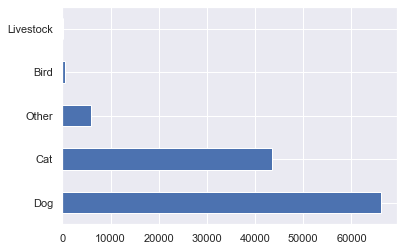

In [194]:
clean_data['animal_type'].value_counts().plot(kind = 'barh')

<Figure size 1440x720 with 0 Axes>

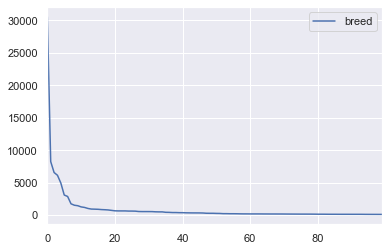

In [195]:
breeds = pd.DataFrame(clean_data['breed'].value_counts()).reset_index()
plt.figure(figsize=(20,10))
breeds.iloc[:100].plot()

Based on this graph, we can see that the frequency of breeds tapers off drastically after the top 10 breeds. The imbalance means that we could probably make breeds after the top 20 in the "Other" category. 

<Figure size 1440x720 with 0 Axes>

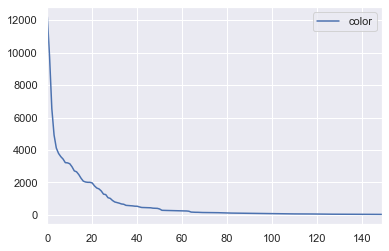

In [196]:
colors = pd.DataFrame(clean_data['color'].value_counts()).reset_index()
plt.figure(figsize=(20,10))
colors.iloc[:150].plot()

Based on this graph, we can see that the frequency of colors tapers off drastically after the top 50 breeds. The imbalance means that we could probably make breeds after the top 60 in the "Other" category. 

<b> FEATURE ENGINEERING: </b>

<i>Overview: We merged categories in the class label to avoid redundancy of labels, for a total of 4 classes: Adoption, Transfer, Return to Owner, and Death. We also created an "Other" attribute for the Breed and Color columns for attributes that had a low frequency. This would simplify things for data analysis since breeds/colors that have very low frequency would not be necessarily helpful, and might just serve as noise. We also took out the dob column because it's redundant with the age column.

In [197]:
clean_data['outcome'].value_counts()

Adoption           51399
Transfer           34460
Return to Owner    20474
Euthanasia          7728
Died                1049
Rto-Adopt            592
Disposal             482
Missing               67
Relocate              20
Name: outcome, dtype: int64

In [198]:
#we can merge some of these outcome types that mean the same thing:
#relocate --> transfer
#disposal --> died
#rto-adopt --> adoption

#take out missing outcomes
#4 final categories: adoption, transfer, return to owner, died.
def merge(outcome):
    if ((outcome == 'Euthanasia') or (outcome == 'Disposal')):
        return 'Died'
    elif (outcome == 'Relocate'):
        return 'Transfer'
    elif (outcome == 'Rto-Adopt'):
        return 'Adoption'
    elif (outcome == 'Missing'):
        return None 
    else:
        return outcome

In [199]:
clean_data['class'] = clean_data.apply(lambda x: merge(x['outcome']), axis = 1)

In [200]:
clean_data.head()

,id,name,date,dob,outcome,animal_type,sex,age,breed,color,class
0,A794011,Chunk,2019-05-08 18:20:00,05/02/2017,Rto-Adopt,Cat,Neutered Male,730.0,Domestic Shorthair Mix,Brown Tabby/White,Adoption
1,A776359,Gizmo,2018-07-18 16:02:00,07/12/2017,Adoption,Dog,Neutered Male,365.0,Chihuahua Shorthair Mix,White/Brown,Adoption
2,A720371,Moose,2016-02-13 17:59:00,10/08/2015,Adoption,Dog,Neutered Male,120.0,Anatol Shepherd/Labrador Retriever,Buff,Adoption
3,A674754,None,2014-03-18 11:47:00,03/12/2014,Transfer,Cat,Intact Male,6.0,Domestic Shorthair Mix,Orange Tabby,Transfer
4,A689724,*Donatello,2014-10-18 18:52:00,08/01/2014,Adoption,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,Adoption


In [201]:
clean_data['class'].value_counts()

Adoption           51991
Transfer           34480
Return to Owner    20474
Died                9259
Name: class, dtype: int64

In [202]:
#drop missing outcomes and drop outcome column
print(clean_data['class'].isna().sum())
clean_data = clean_data.dropna(subset = ['class'])
clean_data = clean_data.drop(columns = ['outcome'])
clean_data.shape

67


(116204, 10)

We also wanted to separate the date into month, day, year, day of the week, and time, so that we can get as much value out of this column as possible.

In [205]:
import datetime as dt
#separate date column into month, day, year, day of the week, and time. 
clean_data['day'] = clean_data.date.dt.day
clean_data['month'] = clean_data.date.dt.month
clean_data['year'] = clean_data.date.dt.year
clean_data['time'] = clean_data.date.dt.time
clean_data['weekday'] = clean_data.date.dt.weekday

In [206]:
clean_data.head()

,id,name,date,dob,animal_type,sex,age,breed,color,class,day,month,year,time,weekday
0,A794011,Chunk,2019-05-08 18:20:00,05/02/2017,Cat,Neutered Male,730.0,Domestic Shorthair Mix,Brown Tabby/White,Adoption,8,5,2019,18:20:00,2
1,A776359,Gizmo,2018-07-18 16:02:00,07/12/2017,Dog,Neutered Male,365.0,Chihuahua Shorthair Mix,White/Brown,Adoption,18,7,2018,16:02:00,2
2,A720371,Moose,2016-02-13 17:59:00,10/08/2015,Dog,Neutered Male,120.0,Anatol Shepherd/Labrador Retriever,Buff,Adoption,13,2,2016,17:59:00,5
3,A674754,None,2014-03-18 11:47:00,03/12/2014,Cat,Intact Male,6.0,Domestic Shorthair Mix,Orange Tabby,Transfer,18,3,2014,11:47:00,1
4,A689724,*Donatello,2014-10-18 18:52:00,08/01/2014,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,Adoption,18,10,2014,18:52:00,5


Another problem we ran into was that there are many different breeds and colors as possible attributes. A lot of these breeds and colors have a very low frequency (i.e. they only show up in the data once). We categorized any breeds or colors under thresholds as "Other".

In [207]:
#threshold for breeds, if under threshold --> "Other". threshold here is top 30!
top_breeds = breeds.iloc[:50]
top_breeds.columns = ['topbreed', 'count']
breed_updated_data = pd.merge(clean_data, top_breeds, how = 'left', left_on = 'breed', right_on = 'topbreed')

In [208]:
print(breed_updated_data.topbreed.isna().sum())
breed_updated_data.topbreed = breed_updated_data.topbreed.fillna(value = 'Other')

25826


In [209]:
breed_updated_data.head()

,id,name,date,dob,animal_type,sex,age,breed,color,class,day,month,year,time,weekday,topbreed,count
0,A794011,Chunk,2019-05-08 18:20:00,05/02/2017,Cat,Neutered Male,730.0,Domestic Shorthair Mix,Brown Tabby/White,Adoption,8,5,2019,18:20:00,2,Domestic Shorthair Mix,30570.0
1,A776359,Gizmo,2018-07-18 16:02:00,07/12/2017,Dog,Neutered Male,365.0,Chihuahua Shorthair Mix,White/Brown,Adoption,18,7,2018,16:02:00,2,Chihuahua Shorthair Mix,6137.0
2,A720371,Moose,2016-02-13 17:59:00,10/08/2015,Dog,Neutered Male,120.0,Anatol Shepherd/Labrador Retriever,Buff,Adoption,13,2,2016,17:59:00,5,Other,NaN
3,A674754,None,2014-03-18 11:47:00,03/12/2014,Cat,Intact Male,6.0,Domestic Shorthair Mix,Orange Tabby,Transfer,18,3,2014,11:47:00,1,Domestic Shorthair Mix,30570.0
4,A689724,*Donatello,2014-10-18 18:52:00,08/01/2014,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,Adoption,18,10,2014,18:52:00,5,Domestic Shorthair Mix,30570.0


In [210]:
#drop regular breed column
breed_updated_data = breed_updated_data.drop(columns = ['breed'])

#threshold for colors, if under threshold --> "Other". threshold here is top 50!
top_colors = colors.iloc[:50]
top_colors.columns = ['topcolor', 'count']
color_updated_data = pd.merge(breed_updated_data, top_colors, how = 'left', left_on = 'color', right_on = 'topcolor')

In [211]:
print(color_updated_data.topcolor.isna().sum())
color_updated_data.topcolor = color_updated_data.topcolor.fillna(value = 'Other')

12294


In [212]:
color_updated_data.head()

,id,name,date,dob,animal_type,sex,age,color,class,day,month,year,time,weekday,topbreed,count_x,topcolor,count_y
0,A794011,Chunk,2019-05-08 18:20:00,05/02/2017,Cat,Neutered Male,730.0,Brown Tabby/White,Adoption,8,5,2019,18:20:00,2,Domestic Shorthair Mix,30570.0,Brown Tabby/White,3441.0
1,A776359,Gizmo,2018-07-18 16:02:00,07/12/2017,Dog,Neutered Male,365.0,White/Brown,Adoption,18,7,2018,16:02:00,2,Chihuahua Shorthair Mix,6137.0,White/Brown,2259.0
2,A720371,Moose,2016-02-13 17:59:00,10/08/2015,Dog,Neutered Male,120.0,Buff,Adoption,13,2,2016,17:59:00,5,Other,NaN,Buff,489.0
3,A674754,None,2014-03-18 11:47:00,03/12/2014,Cat,Intact Male,6.0,Orange Tabby,Transfer,18,3,2014,11:47:00,1,Domestic Shorthair Mix,30570.0,Orange Tabby,3218.0
4,A689724,*Donatello,2014-10-18 18:52:00,08/01/2014,Cat,Neutered Male,60.0,Black,Adoption,18,10,2014,18:52:00,5,Domestic Shorthair Mix,30570.0,Black,9735.0


In [215]:
#dataset is ready for model!
final_data = color_updated_data.filter(items = ['animal_type', 'sex', 'age', 'topbreed', 
                                                'topcolor', 'day', 'month', 'year', 'time','class'])
final_data.columns = ['animal_type', 'sex', 'age', 'breed', 'color', 'day', 'month', 'year', 'time','class']
final_data.head()

,animal_type,sex,age,breed,color,day,month,year,time,class
0,Cat,Neutered Male,730.0,Domestic Shorthair Mix,Brown Tabby/White,8,5,2019,18:20:00,Adoption
1,Dog,Neutered Male,365.0,Chihuahua Shorthair Mix,White/Brown,18,7,2018,16:02:00,Adoption
2,Dog,Neutered Male,120.0,Other,Buff,13,2,2016,17:59:00,Adoption
3,Cat,Intact Male,6.0,Domestic Shorthair Mix,Orange Tabby,18,3,2014,11:47:00,Transfer
4,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,18,10,2014,18:52:00,Adoption


Data is ready for model input!